In [1]:
def readTextFile(path):
    with open(path) as f:
        captions=f.read()
    
    return captions

In [2]:
captions=readTextFile('captions.txt')
captions=captions.split('\n')

In [3]:
descriptions={}

for x in captions:
    first=x.split('.jpg,')[0]
    second=x.split('.jpg,')[1]
    img_name=first

    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]

    descriptions[img_name].append(second)

In [4]:
IMG_PATH='Images/'
import cv2
import matplotlib.pyplot as plt 

In [5]:
import re

def clean_text(sentence):
    sentence=sentence.lower()
    sentence=re.sub('[^a-z]+'," ",sentence)
    sentence=sentence.split()

    sentence=[s for s in sentence if len(s)>1]
    sentence=" ".join(sentence)

    return sentence

In [6]:
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i]=clean_text(caption_list[i])

In [7]:
with open('descriptions.txt','w') as f:
    f.write(str(descriptions))

In [8]:
import json

descriptions=None 

with open('descriptions.txt','r') as f:
    descriptions=f.read()

json_acceptable_string=descriptions.replace("'","\"")
descriptions=json.loads(json_acceptable_string)

In [9]:
vocab=set()

for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

print('Vocab size %d'% len(vocab))

Vocab size 8424


In [10]:
total_words=[]

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]

print('Total Words %d'%len(total_words))

Total Words 373803


In [11]:
import collections

counter=collections.Counter(total_words)
freq_cnt=dict(counter)
print(len(freq_cnt.keys()))

8424


In [12]:
sorted_freq_cnt=sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

threshold=10
sorted_freq_cnt=[x for x in sorted_freq_cnt if x[1]>threshold]
total_words=[x[0] for x in sorted_freq_cnt]

In [13]:
keys_list=list(descriptions.keys())

In [14]:
train_descriptions={}

for img_id in keys_list[:6000]:
    train_descriptions[img_id]=[]
    for cap in descriptions[img_id]:
        cap_to_append='startseq '+cap+' endseq'
        train_descriptions[img_id].append(cap_to_append)

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

model=ResNet50(weights='imagenet',input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [16]:
model_new=Model(model.input,model.layers[-2].output)

In [17]:
def preprocess_img(img):
    img=image.load_img(img,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)

    img=preprocess_input(img)

    return img

In [18]:
from tensorflow.keras.preprocessing import image
import numpy as np 
from tensorflow.keras.applications.resnet50 import preprocess_input

In [19]:
def encode_image(img):
    img=preprocess_img(img)
    feature_vector=model_new.predict(img)
    feature_vector=feature_vector.reshape((-1,))
    return feature_vector

In [20]:
from time import time

# start=time()
# encoding_train={}

# for ix,img_id in enumerate(keys_list[:6000]):
#     img_path=IMG_PATH+'/'+img_id+'.jpg'
#     encoding_train[img_id]=encode_image(img_path)

#     if ix%100==0:
#         print('Encoding in progress time step %d '%ix)

# end_t=time()
# print('Total time taken :',end_t-start)

In [21]:
import pickle

# with open('encoded_train_features.pkl','wb') as f:
#     pickle.dump(encoding_train,f)

In [22]:
# start=time()
# encoding_test={}

# for ix,img_id in enumerate(keys_list[6000:7000]):
#     img_path=IMG_PATH+'/'+img_id+'.jpg'
#     encoding_test[img_id]=encode_image(img_path)

#     if ix%100==0:
#         print('Encoding in progress time step %d '%ix)

# end_t=time()
# print('Total time taken :',end_t-start)

In [23]:
# with open('encoded_test_features.pkl','wb') as f:
#     pickle.dump(encoding_test,f)

In [24]:
with open('encoded_train_features.pkl', 'rb') as f:
    encoding_train = pickle.load(f)

In [25]:
with open('encoded_test_features.pkl', 'rb') as f:
    encoding_test = pickle.load(f)

In [26]:
word_to_idx={}
idx_to_word={}

for i,word in enumerate(total_words):
    word_to_idx[word]=i+1
    idx_to_word[i+1]=word 

In [27]:
idx_to_word[1846]='startseq'
word_to_idx['startseq']=1846

idx_to_word[1847]='endseq'
word_to_idx['endseq']=1847

vocab_size=len(word_to_idx)+1
print('Vocab Size',vocab_size)

Vocab Size 1848


In [28]:
max_len=0

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len=max(max_len,len(cap.split()))

print(max_len)

35


In [29]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2,y=[],[],[]

    n=0
    while True:
        for key,desc_list in train_descriptions.items():
            n+=1

            photo=encoding_train[key]
            for desc in desc_list:
                seq=[word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi=seq[0:i]
                    yi=seq[i]

                    xi=pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi=to_categorical([yi],num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)

                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y=[],[],[]
                    n=0

In [30]:
embedding_index={}

f=open('glove.6B.50d.txt',encoding='utf8')

for line in f:
    values=line.split()

    word=values[0]
    word_embedding=np.array(values[1:],dtype='float')
    embedding_index[word]=word_embedding

f.close()

In [31]:
def get_embedding_matrix():
    emb_dim=50
    matrix=np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector=embedding_index.get(word)

        if embedding_vector is not None:
            matrix[idx]=embedding_vector

    return matrix

In [32]:
embedding_matrix=get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [33]:
from keras.layers import *
from keras.models import *

input_img_features=Input(shape=(2048,))
inp_img1=Dropout(0.3)(input_img_features)
inp_img2=Dense(256,activation='relu')(inp_img1)

In [34]:
input_captions=Input(shape=(max_len,))
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)

In [35]:
decoder1=add([inp_img2,inp_cap3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

model=Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [36]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 35, 50)               92400     ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

In [37]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False

In [38]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [39]:
epochs=20
batch_size=3
steps=len(train_descriptions)//batch_size

In [40]:
def train():
    for i in range(epochs):
        generator=data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('model_weights/model_'+str(i)+'.h5')

In [41]:
# train()

In [42]:
model=load_model('model_weights/model_19.h5')

In [43]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

1/1 [==============================] - 0s 21ms/step
man in red kayak wave


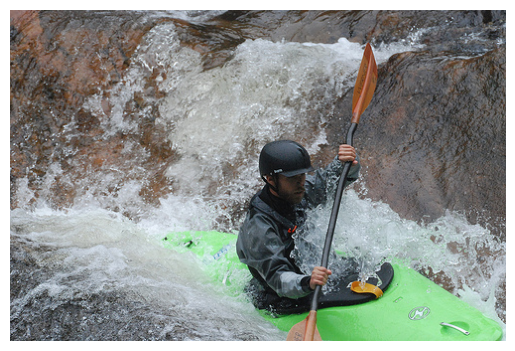

1/1 [==============================] - 0s 22ms/step
group of people dressed in costumes


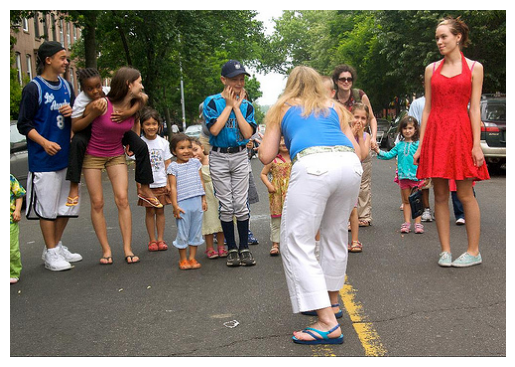

1/1 [==============================] - 0s 20ms/step
man in red coat is holding basketball in front of crowd


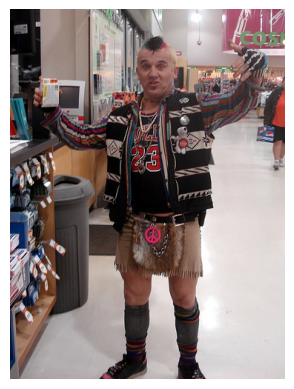

1/1 [==============================] - 0s 21ms/step
man in white shirt is performing basketball


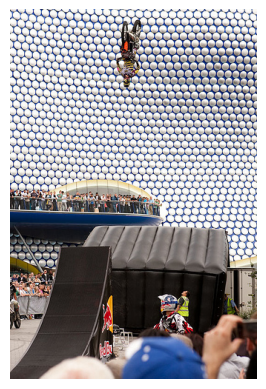

1/1 [==============================] - 0s 21ms/step
the opposing team in red uniform is preparing to tackle the ball


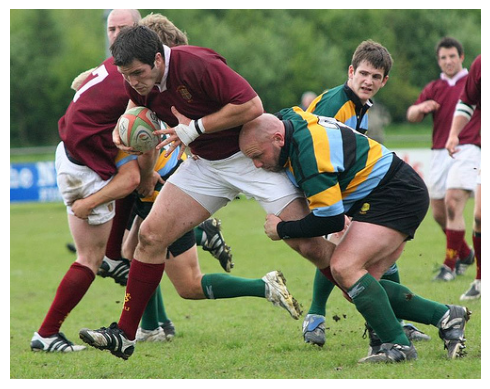

1/1 [==============================] - 0s 21ms/step
man in black shirt is sitting on the sidewalk with his foot spread paint of her tricycle


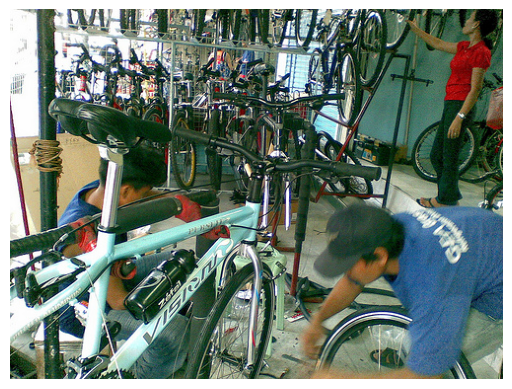

1/1 [==============================] - 0s 23ms/step
boy is jumping his bike off ramp


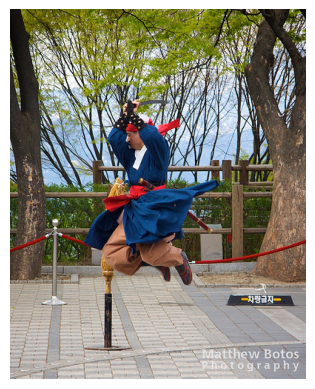

1/1 [==============================] - 0s 22ms/step
young boy is holding his hair and picking


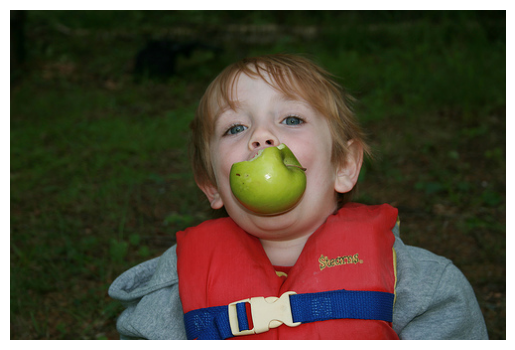

1/1 [==============================] - 0s 23ms/step
man in yellow shirt is jumping his bike in the air


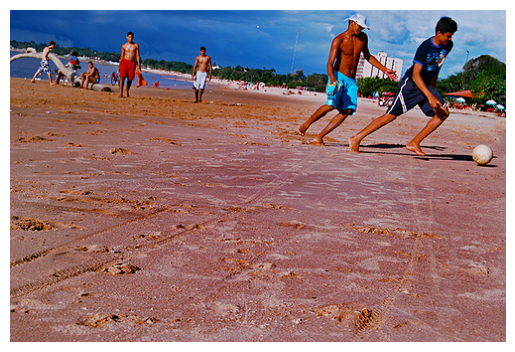

1/1 [==============================] - 0s 22ms/step
man in blue shirt is jumping his bike on the top of the dirt


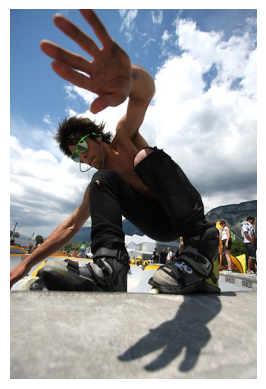

1/1 [==============================] - 0s 21ms/step
man is standing on cliff with his hand up to safety rope


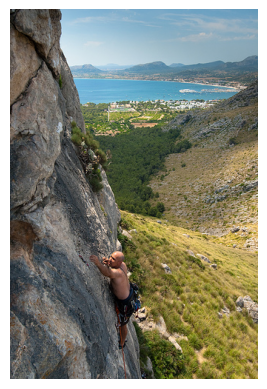

1/1 [==============================] - 0s 21ms/step
surfer is riding wave


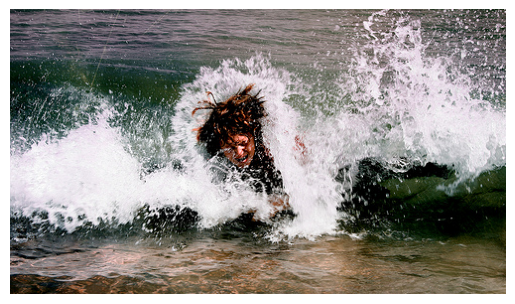

1/1 [==============================] - 0s 24ms/step
man in blue shirt is jumping his bike on ramp


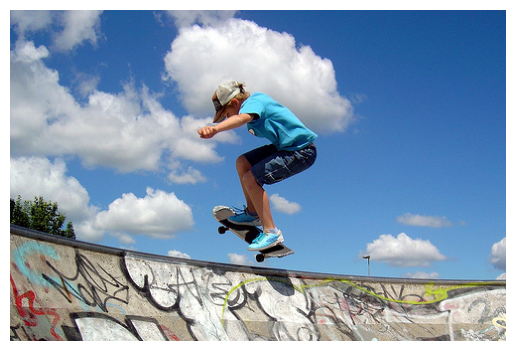

1/1 [==============================] - 0s 21ms/step
group of people in front of


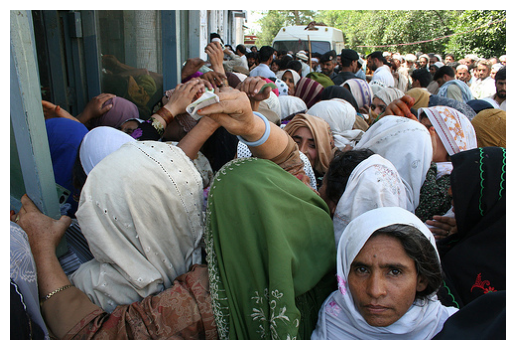

1/1 [==============================] - 0s 22ms/step
group of people are standing in front of


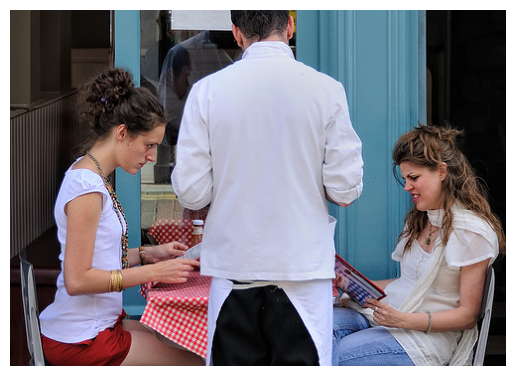

In [44]:
for i in range(15):
    idx=np.random.randint(0,1000)
    all_img_names=list(encoding_test.keys())
    img_name=all_img_names[idx]
    photo_2048=encoding_test[img_name].reshape((1,2048))

    i=plt.imread('Images/'+img_name+'.jpg')
    caption=predict_caption(photo_2048)
    print(caption)
    plt.imshow(i)
    plt.axis('off')
    plt.show()